# Lobsters Logistic Redux
## Adam Viray, Claire Gilder, Marie Johnson
Let's return to the lobster problem, but this I'd like you to use logistic regression to find the solution.  First, the data:

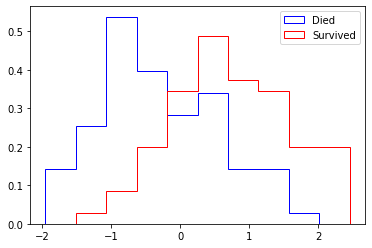

159


In [1]:
import numpy as np
import matplotlib.pyplot as plt
data = np.loadtxt('datasets/lobster_survive.dat',skiprows=1)
X,Y = data.T

# normalize X
X -= X.mean()
X /= X.std()

# histogram plotting
bins = np.unique(X)
plt.hist(X[Y==0],bins,histtype='step',density=True,label='Died',color='blue')
plt.hist(X[Y==1],bins,histtype='step',density=True,label='Survived',color='red')
plt.legend()
plt.show()
varX = np.var(X) #sigma^2 is the variance
print (len(X))

We would still like to know
$$
P(\text{Survive}=1|\text{Length}=x),
$$
where $\text{Survive}$ is a variable indicating whether the lobster survived or not, and $\text{Length}$ is the length of the lobster ($x\in\mathcal{R}$).  

In logistic regression, we will approach this directly by implementing logistic regression, where we model
$$
P(\text{Survive}=1|\text{Length}=x) = \sigma(\Phi \mathbf{w}).
$$
First implement the logistic function
$$
\sigma(z) = \frac{1}{1 + \mathrm{exp}(-z)}
$$

In [2]:
def sigmoid(z):
    sigma = 1/(1+np.exp(-z))
    return sigma

Next, define the log-posterior function
$$
\mathcal{L}(\mathbf{w};\mathbf{X}_{obs},\mathbf{Y}_{obs}) = \sum_{i=1}^m [Y_{obs,i} \ln \sigma(\Phi_i \mathbf{w}) + (1-Y_{obs,i}) \ln (1-\sigma(\Phi_i \mathbf{w}))] - \lambda \mathbf{w}^T \mathbf{w} 
$$

$$
\nabla_\mathbf{w} \mathcal{L} = \sum_{i=1}^m \left[ (\mathbf{Y}_{obs,i} - \sigma(\Phi_i \mathbf{w})) \Phi_i\right] - \lambda\mathbf{w}^T. 
$$

In [3]:
def L(w,X,Y,var_w):
    
    def Phi(X):
        # design matrix
        n = len(X)
        phi = np.ones((n,2))
        phi[:,1] = X
        return phi
    
    lamda = varX/var_w
    
    likelihood = -1*lamda*w.T@w # set initial value to -lambda*w.T*w
    grad_likelihood = -lamda*w.T # set initial value to -lambda*w.T
    
    design_matrix = Phi(X)
    
    for i in range(1, len(X)): 
        phi = design_matrix[i] # a given row of phi
        sigma = sigmoid(z = phi@w)
        likelihood += Y[i] * np.log(sigma) + (1 -Y[i])*np.log(1-sigma) #sum terms 
        grad_likelihood += (Y[i] - sigma)*phi #sum term (used for quiverplot)
    
    return np.array([likelihood,grad_likelihood[0],grad_likelihood[1]])

We currently lack the tools necessary to minimize this function elegantly, but we can attack it using brute force.  Make the assumption that 
$$
y_i = w_0 + w_1 X_{obs,i}.
$$
Using either a grid-search approach (check out numpy.meshgrid) or a random sampling approach, search for the values of $\mathbf{w}$ that maximizes this likelihood function.  Plot all computed values of $\mathcal{L}(\mathbf{w})$ as a function of $\mathbf{w}$.  Useful commands for this plotting if you take the grid search approach might be plt.contourf.  For the random sampling approach, you might try plt.scatter (using the c= keyword argument).


In [5]:
# Develop a method to find the best values of w_0 and w_1.  
var_w = 1 #this is pulled out the air.

w_arr = np.random.normal(0, var_w, (1000,2)) # random sample for our parameters
L_arr = np.zeros((1000,3))

for i,w in enumerate(w_arr):
    L_arr[i] = -1*L(w,X,Y,var_w)
lowpoint = w_arr[np.argmin(L_arr[:,0]),:]
print("w vector:", np.exp(lowpoint[0]), lowpoint[1])

w vector: 1.0042332637033242 1.200649220238186


Using this best parameter set, plot lobster survival as a function of length.  

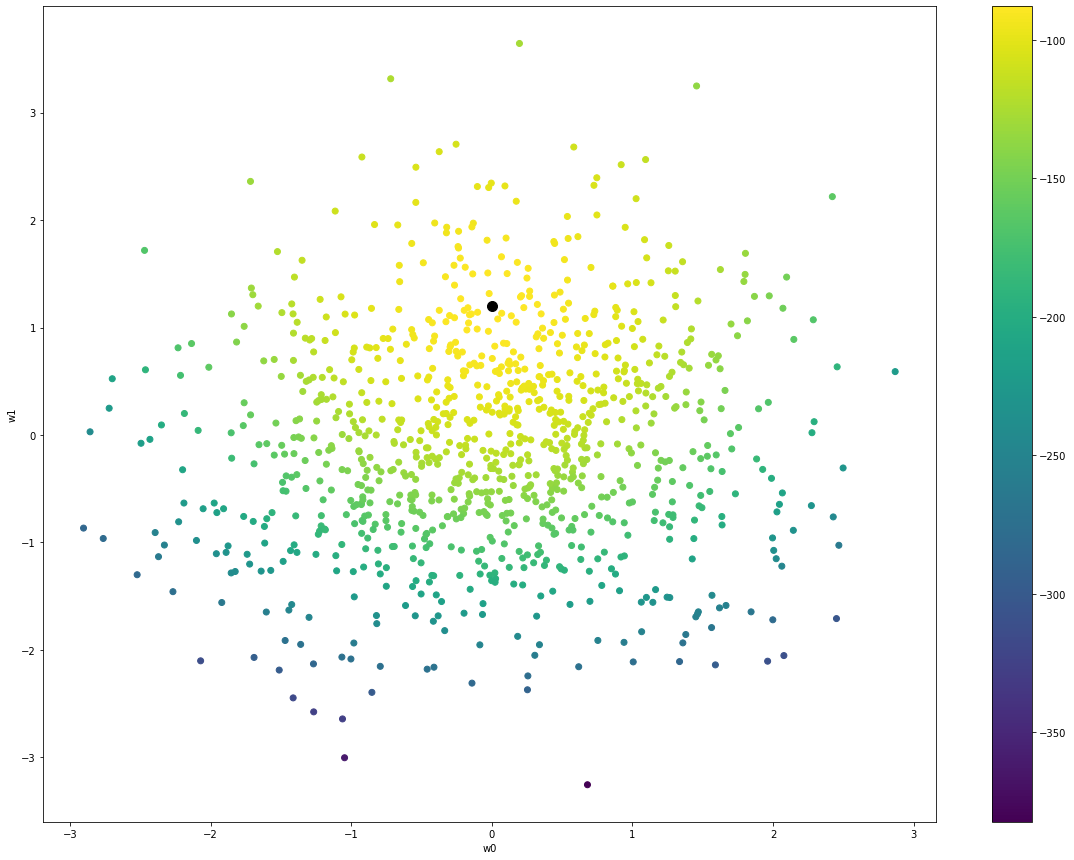

In [6]:
plt.figure(figsize=(20,15))
plt.scatter(w_arr[:,0],w_arr[:,1],c=-L_arr[:,0])
plt.colorbar()
plt.scatter(lowpoint[0],lowpoint[1],c='k',s=100)
plt.xlabel("w0")
plt.ylabel("w1")
plt.show()

As a final bonus round, check out the matplotlib function plt.quiver, which is a useful command for plotting gradients (in 2D).  The gradient of the log-posterior function is 
$$
\nabla_\mathbf{w} \mathcal{L} = \sum_{i=1}^m \left[ (\mathbf{Y}_{obs,i} - \sigma(\Phi_i \mathbf{w})) \Phi_i\right] - \lambda\mathbf{w}^T. 
$$
Use the quiver command to produce a plot visualizing the gradient of the log-posterior.  Given this information, can you determine a more efficient way than brute force to find the maximum value of $\mathcal{L}(\mathbf{w}$?

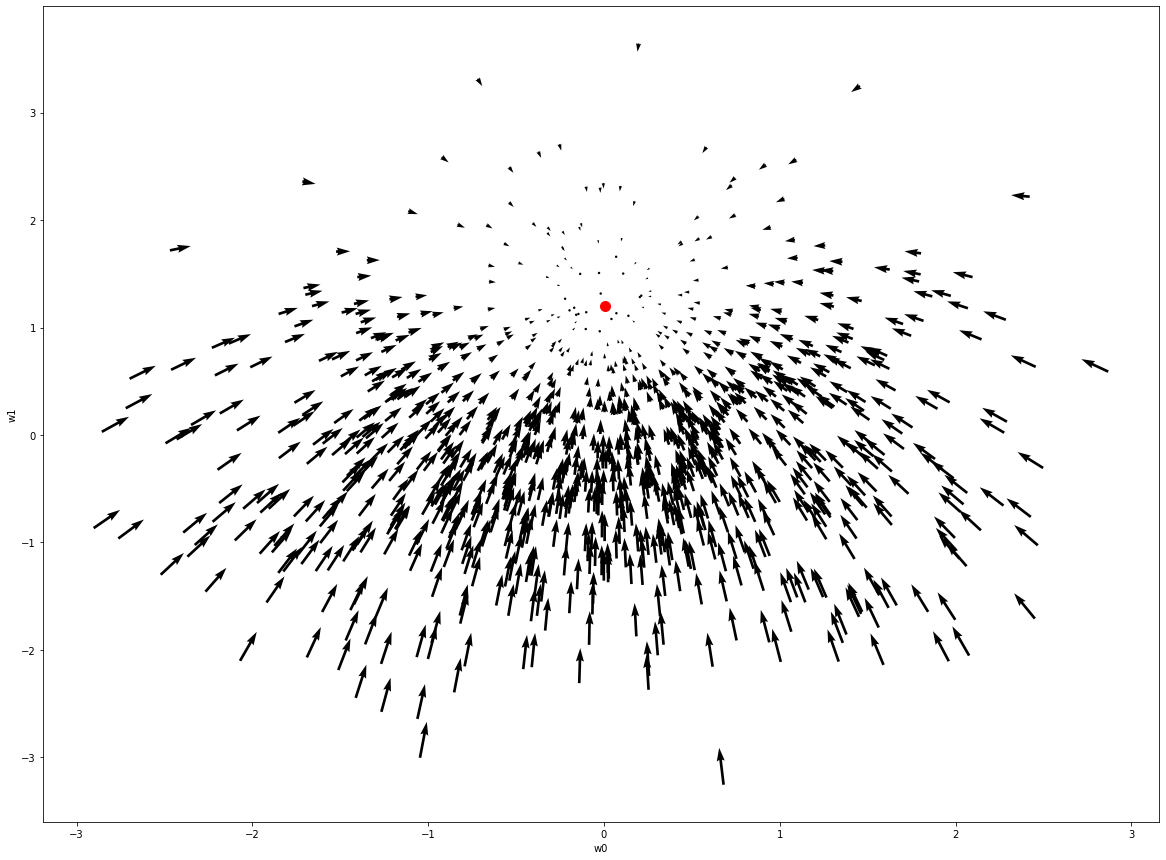

In [7]:
%matplotlib inline
x_pos = w_arr[:,0]
y_pos = w_arr[:,1]
x_dir = -L_arr[:,1]
y_dir = -L_arr[:,2]

plt.figure(figsize=(20,15))
plt.quiver(x_pos,y_pos,x_dir,y_dir)
plt.scatter(lowpoint[0],lowpoint[1],c='r',s=100)
plt.xlabel("w0")
plt.ylabel("w1")
plt.show()

#! use plt.quiver to visualize the gradients of the log-posterior.

More efficient than brute-forcing for maximum likelihood, we can utilize the gradient and follow it down (or up, in the case of gradient ascent) until we reach a sufficiently flat spot (where the gradient is below a preset threshold).

# Gradient Descent

If you successfully completed the previous notebook, you'll now have a good understanding that we can view the log-likelihood function as a landscape.  Unfortunately, it's the rare problem for which that landscape actually exists in 2-dimensions like our own physical topography.  Indeed, for machine learning this landscape often has thousands or millions of dimensions.  This precludes the possibility of finding optimal solutions through grid searches.

The alternative to brute force is gradient descent.  Here we'll take the convention of trying to minimize a so-called *cost function*, which for our purposes is just -1 times the log-posterior we've been working with (for historical reasons, the machine learning literature tends to think of optimization problems in terms of minimizing a cost function, as opposed to maximizing a log-posterior, even though the two viewpoints are equivalen).  For the lobster problem, the cost function to minimize is 
$$
\mathcal{L}(\mathbf{w};\mathbf{X}_{obs},\mathbf{Y}_{obs}) = -\sum_{i=1}^m \left[Y_{obs,i} \ln \sigma(\Phi_i \mathbf{w}) + (1-Y_{obs,i}) \ln (1-\sigma(\Phi_i \mathbf{w}))\right] + \lambda \mathbf{w}^T \mathbf{w}. 
$$
The gradient of this function is 
$$
\nabla_\mathbf{w} \mathcal{L} = -\sum_{i=1}^m \left[ (Y_{obs,i} - \sigma(\Phi_i \mathbf{w})) \Phi_i\right] + \lambda\mathbf{w}^T. 
$$
Gradient descent is implemented by sequentially updating the model parameters as
$$
\mathbf{w}_{t+1} = \mathbf{w}_t - \eta \nabla_{\mathbf{w}} \mathcal{L}.
$$
**Return to the lobster problem, and attempt to find the optimal value of $\mathbf{w}$ using gradient descent.  You'll have to select both a sensible initial guess for $\mathbf{w}$, as well as a value of $\eta$: too big, and it'll do some crazy things, too small and you won't get anywhere.  Because you've already solved this problem using grid search, you know the solution that you're trying to achieve.  Plot the trajectory of parameter values over the loss surface that you constructed for the brute force method (this is very helpful for debugging).**

In [8]:
def grad_L(w,X,Y,var_w):
    
    def Phi(X):
        # design matrix
        n = len(X)
        phi = np.ones((n,2))
        phi[:,1] = X
        return phi
    
    lamda = varX/var_w
    grad_likelihood = lamda*w.T # set initial value to -lambda*w.T
    design_matrix = Phi(X)
    
    for i in range(1, len(X)): 
        phi = design_matrix[i] # a given row of phi
        sigma = sigmoid(z = phi@w)
        grad_likelihood -= (Y[i] - sigma)*phi #sum term (used for quiverplot)
    
    return np.array([grad_likelihood[0],grad_likelihood[1]])

In [82]:
eta = .01
w_pos = np.abs(w_arr[np.random.randint(0,1000)])
path = np.empty((4))
repeat = True

while repeat:
    w_vec = grad_L(w_pos,X,Y,var_w)
    path = np.vstack((path, np.array([w_pos[0],w_pos[1],w_vec[0],w_vec[1]])))
    w_pos -= eta*w_vec
    
    if np.linalg.norm(eta*w_vec)<1e-6:
        repeat = False

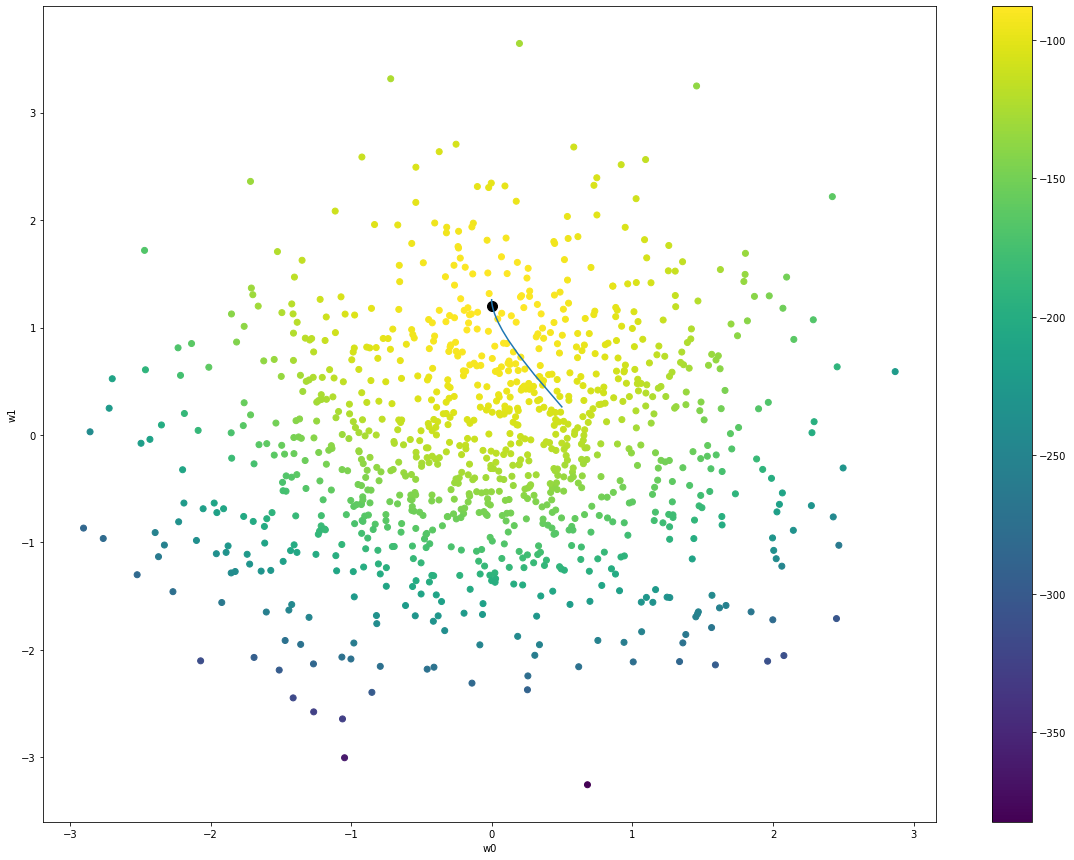

In [83]:
plt.figure(figsize=(20,15))
plt.scatter(w_arr[:,0],w_arr[:,1],c=-L_arr[:,0])
plt.plot(path[1:,0],path[1:,1])
plt.colorbar()
plt.scatter(lowpoint[0],lowpoint[1],c='k',s=100)
plt.xlabel("w0")
plt.ylabel("w1")
plt.show()

In [97]:
x_space = np.linspace(-3,3,100)
y_space = np.linspace(-3,3,100)
LL = np.empty((100,100))
for i in range(100):
    for j in range(100):
        w = np.array([x_space[i], y_space[j]])
        LL[i,j] = L(w,X,Y,var_w)[0]

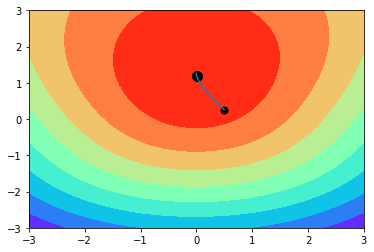

In [102]:
plt.contourf(x_space,y_space,LL.T,10,cmap='rainbow')
plt.scatter(path[1,0],path[1,1],c='k',s=50)
plt.scatter(lowpoint[0],lowpoint[1],c='k',s=100)
plt.plot(path[1:,0],path[1:,1])
plt.show()